## <p align="center"> Customer Segmentation Classification

<div>
<img style="float:right" width="300" height="400" src="https://images.squarespace-cdn.com/content/v1/5cc22d6593a63233d214110c/1574701437270-KR9OAENC9PYIJ03P2YKA/Car-Logos_Blog-image.png">
</div>



### Table of Contents
- [Importing Basic Libraries](#Imports)
- [Data Collection](#Read)
- [Formate](#Formate)
- [Feature Engineering](#Feature)
- [Drop ot needed columns](#Drop)
- [Defining X and y](#Define)
- [Build our feature list for cat. and numeric](#Build)
- [Dummy variables and label encoder](#Dummy)
- [Split the data](#split)
- [BaseLine Model with numerical cols (Expr0)](#BaseLine)
- [scaling](#sc)
- [KNeighbors Classifier](#knn)
- [DecisionTreeClassifier](#tree)
- [Random Forest Classifier](#random)
- [XGBClassifier](#xgb)
- [Gaussian Naive Bayes](#naive)


<a id='Imports'></a>
### Importing Basic Libraries

In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
import warnings
warnings.filterwarnings("ignore")

<a id='Read'></a>
### Data Collection

In [472]:
data= pd.read_csv("TrainSE.csv")
df= data.copy()

In [473]:
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [474]:
#Checking dataset info by feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [475]:
df.shape
#We have 8068 total rows and 11 columns

(8068, 11)

In [476]:
df.dropna(axis=0, how='any', thresh=None, subset=None , inplace=True)

In [477]:
#Missing values?
df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [478]:
#Checking the existence of duplicated rows
df.duplicated().sum()

0

In [479]:
df.drop(["Work_Experience"],axis=1, inplace=True)
df["Ever_Married"].fillna("No", inplace=True)
df["Graduated"].fillna("No", inplace=True)
df.dropna(subset=["Profession"], inplace=True)
df.dropna(subset=["Var_1"], inplace=True)
df["Family_Size"].fillna(df["Family_Size"].mean(), inplace=True)

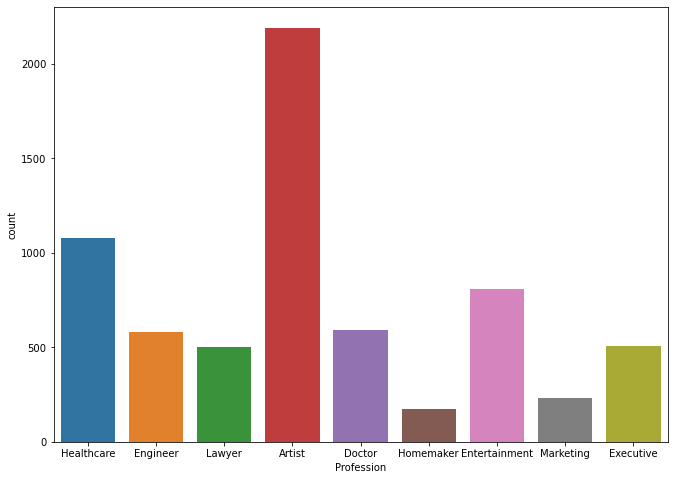

In [480]:
plt.figure(figsize=(11,8))
sns.countplot(df.Profession);

In [481]:
plt.figure(figsize=(7,8))
px.pie(df['Spending_Score'].value_counts().reset_index(),values= 'Spending_Score', names = ['Low ', 'Average','High'] , hole =0.6)

<Figure size 504x576 with 0 Axes>

Median value of Family size feature is: 2.0


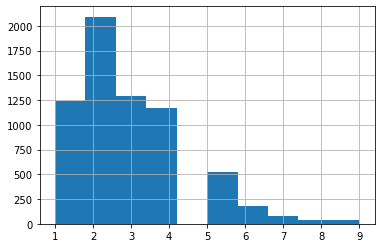

In [482]:
df['Family_Size'].hist()
print("Median value of Family size feature is:",df['Family_Size'].median())

In [483]:
# Visualize Target Label Distribution
plot_data = data.groupby('Segmentation')['Segmentation'].agg(['count']).reset_index()

fig = px.pie(plot_data, values = plot_data['count'], names = plot_data['Segmentation'])

fig.update_traces(textposition = 'inside', textinfo = 'percent + label', hole = 0.5, 
                  marker = dict(colors = ['#2A3132','#336B87'], line = dict(color = 'white', width = 2)))

fig.update_layout(title_text = 'Customer<br>Segmentation', title_x = 0.5, title_y = 0.55, title_font_size = 26, 
                  title_font_family = 'Calibri', title_font_color = 'black', showlegend = False)
                  
fig.show()

In [484]:
#Checking data balancing (for classification)
auto_balancing = pd.DataFrame()
auto_balancing["Count"] = df["Segmentation"].value_counts()
auto_balancing["Count%"] = df["Segmentation"].value_counts()/df.shape[0]*100
auto_balancing

,Count,Count%
D,1757,26.361590
C,1720,25.806452
A,1616,24.246062
B,1572,23.585896


In [485]:
# Customer Type Based On Gender
gender_based = pd.pivot_table(df,values='ID',index=['Gender'],columns=['Segmentation'],aggfunc=np.count_nonzero)
gender_based

Segmentation,A,B,C,D
Gender,,,,
Female,740,732,795,721
Male,876,840,925,1036


In [486]:
#Data Cleaning

In [487]:
df.drop_duplicates(inplace=True)

In [488]:
#Remove column ID as it´s not important to the model
df.drop(["ID"], axis=1, inplace=True)

### Data Exploration

(array([], dtype=float64), [])

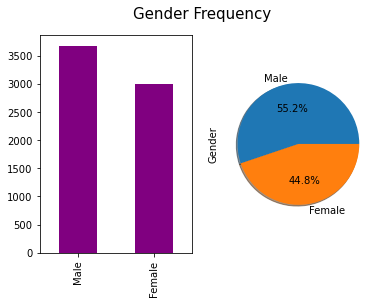

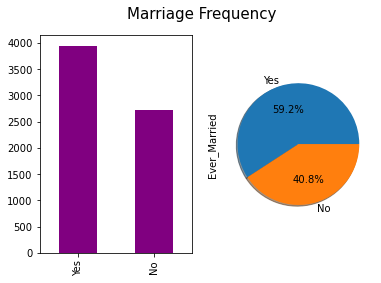

In [489]:

#Plotting Categorical Variables


fig, ax = plt.subplots(1, 2)
df["Gender"].value_counts().plot.bar(color="purple", ax=ax[0])
df["Gender"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Gender Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

fig, ax = plt.subplots(1, 2)
df["Ever_Married"].value_counts().plot.bar(color="purple", ax=ax[0])
df["Ever_Married"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Marriage Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)


(array([], dtype=float64), [])

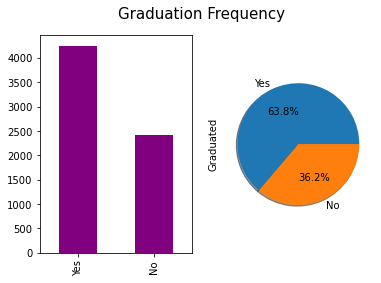

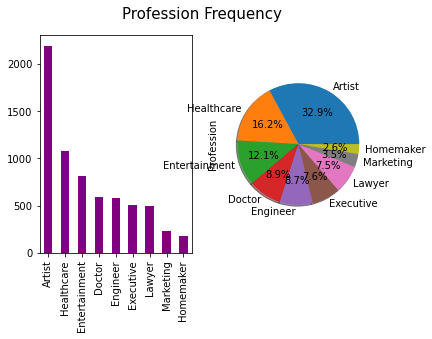

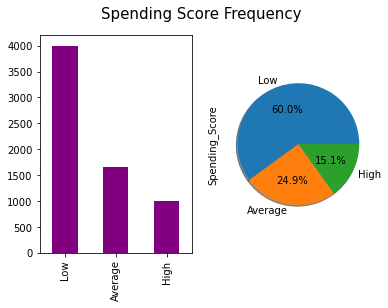

In [490]:
#Plotting Categorical Variables
fig, ax = plt.subplots(1, 2)
df["Graduated"].value_counts().plot.bar(color="purple", ax=ax[0])
df["Graduated"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Graduation Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

fig, ax = plt.subplots(1, 2)
df["Profession"].value_counts().plot.bar(color="purple", ax=ax[0])
df["Profession"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Profession Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

fig, ax = plt.subplots(1, 2)
df["Spending_Score"].value_counts().plot.bar(color="purple", ax=ax[0])
df["Spending_Score"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Spending Score Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

In [491]:
#Defining X and y
X = df.drop("Segmentation",axis="columns")
y = df['Segmentation']

In [492]:
#Build our feature list for cat. and numeric 
num_list = X.select_dtypes(include=np.number).columns
cat_list = X.select_dtypes(exclude=np.number).columns

In [493]:
#Checking basic statistical data by feature
X.describe(include="all")

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
count,6665,6665,6665.000000,6665,6665,6665,6665.000000,6665
unique,2,2,NaN,2,9,3,NaN,7
top,Male,Yes,NaN,Yes,Artist,Low,NaN,Cat_6
freq,3677,3944,NaN,4249,2192,3999,NaN,4476
mean,NaN,NaN,43.536084,NaN,NaN,NaN,2.841110,NaN
std,NaN,NaN,16.524054,NaN,NaN,NaN,1.524743,NaN
min,NaN,NaN,18.000000,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,31.000000,NaN,NaN,NaN,2.000000,NaN
50%,NaN,NaN,41.000000,NaN,NaN,NaN,2.000000,NaN
75%,NaN,NaN,53.000000,NaN,NaN,NaN,4.000000,NaN


In [494]:
#Build our feature list for cat. and numeric 
num_list=X.select_dtypes(include=np.number).columns
cat_list=X.select_dtypes(exclude=np.number).columns
print(num_list,cat_list)

Index(['Age', 'Family_Size'], dtype='object') Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='object')


In [495]:
X=pd.get_dummies(X,drop_first=True)
X.head()

,Age,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,4.0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
2,67,1.0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,67,2.0,1,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
5,56,2.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,32,3.0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [496]:
#Model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [497]:
def model_eval(mdl_local, X_local, y_local, bta = 1):
    y_predl = mdl_local.predict(X_local)
    print(f'Test  : {mdl_local.score(X_local, y_local)}')
    print(f"F({bta}):", fbeta_score(y_local, y_predl, beta= bta ,average='weighted'))
    print("Precision :", precision_score(y_local, y_predl,average='weighted'))
    print("Recall :", recall_score(y_local, y_predl,average='weighted'))

<a id='BaseLine'></a>
# BaseLine Model 

In [498]:
#BaseLine Model with numerical cols (Expr0)

baseline1=LogisticRegression()
baseline1.fit(X_train[num_list],y_train)
print(f'Train : { baseline1.score(X_train[num_list],y_train)}')
model_eval(baseline1,X_test[num_list],y_test, bta = 1)

Train : 0.4172918229557389
Test  : 0.423105776444111
F(1): 0.37260257337494035
Precision : 0.3785512658627358
Recall : 0.423105776444111


In [499]:
#BaseLine Model with all the data dummy included(Expr1)

baseline2=LogisticRegression()
baseline2.fit(X_train,y_train)
print(f'Train : { baseline2.score(X_train,y_train)}')
model_eval(baseline2,X_test,y_test, bta = 1)

Train : 0.5043135783945987
Test  : 0.5258814703675919
F(1): 0.5153206321853078
Precision : 0.5217644984639092
Recall : 0.5258814703675919


In [500]:
y_pred =baseline2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.43      0.51      0.47       324
           B       0.44      0.24      0.31       304
           C       0.52      0.63      0.57       336
           D       0.67      0.68      0.68       369

    accuracy                           0.53      1333
   macro avg       0.52      0.52      0.51      1333
weighted avg       0.52      0.53      0.52      1333



Text(51.0, 0.5, 'Actual')

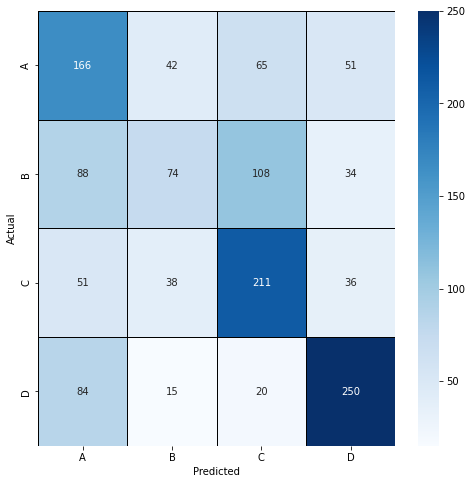

In [501]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['A','B','C','D'] , yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

<a id='sc'></a>
# StandardScaler

In [502]:
# Expr2: with scaling (standard scaler)

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)


std_ml = LogisticRegression()
std_ml.fit(X_train_std, y_train)
print(f'Train : {std_ml.score(X_train_std, y_train)}')
model_eval(std_ml, X_test_std, y_test, bta = 1)

Train : 0.5219429857464366
Test  : 0.5303825956489122
F(1): 0.5183385318824778
Precision : 0.5206725318512152
Recall : 0.5303825956489122


In [503]:
# Expr2: with scaling (minmax scaler)
from sklearn.preprocessing import MinMaxScaler
std_mm = MinMaxScaler()

X_train_mm = std_mm.fit_transform(X_train)
X_test_mm = std_mm.transform(X_test)


std_mm_ml = LogisticRegression()
std_mm_ml.fit(X_train_mm, y_train)
print(f'Train : {std_mm_ml.score(X_train_mm, y_train)}')
model_eval(std_mm_ml, X_test_mm, y_test, bta = 1)

Train : 0.5232558139534884
Test  : 0.5326331582895724
F(1): 0.5212804974663068
Precision : 0.5236887842504068
Recall : 0.5326331582895724


# Logistic Regression

In [504]:
# Expr3: with grid search
from sklearn.model_selection import GridSearchCV
lr_ml = LogisticRegression()
prams ={'penalty': [ 'l1', 'l2'],'C': [2,3,4,5 ]}
gs_cv1= GridSearchCV(lr_ml , param_grid=prams, n_jobs=-1 ,cv=10)
gs_cv1.fit(X_train_std,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [2, 3, 4, 5], 'penalty': ['l1', 'l2']})

In [505]:
from sklearn.model_selection import GridSearchCV
tuned_lr = gs_cv1.best_estimator_
print(f'Train : {tuned_lr.score(X_train_std, y_train)}')
model_eval(tuned_lr,X_test_std,y_test,bta = 1)

Train : 0.521755438859715
Test  : 0.5303825956489122
F(1): 0.5183385318824778
Precision : 0.5206725318512152
Recall : 0.5303825956489122


<a id='knn'></a>
# KNeighbors Classifier

In [506]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_std,y_train)
print(knn_model.score(X_train_std,y_train))
print(knn_model.score(X_test_std,y_test))

0.6325956489122281
0.49212303075768943


In [507]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred =knn_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.29      0.25      0.27       324
           B       0.32      0.03      0.05       304
           C       0.27      0.78      0.40       336
           D       0.89      0.13      0.23       369

    accuracy                           0.30      1333
   macro avg       0.44      0.30      0.24      1333
weighted avg       0.46      0.30      0.24      1333



Text(51.0, 0.5, 'Actual')

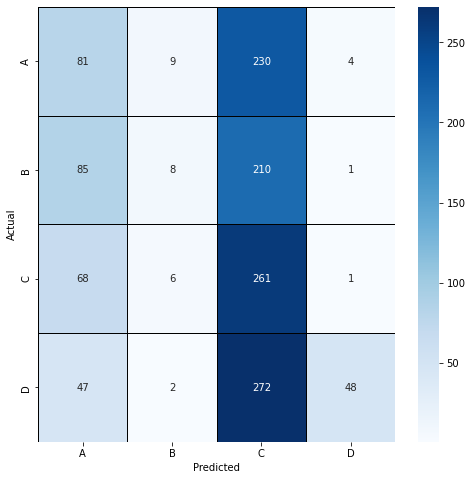

In [508]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['A','B','C','D'] , yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [509]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
prams ={ 'n_neighbors':[13,15,18,22]}
gd_knn= GridSearchCV(knn_model , param_grid=prams, n_jobs=-1 ,cv=10)
gd_knn.fit(X_train_std , y_train) 
gd_knn.best_estimator_  

KNeighborsClassifier(n_neighbors=18)

In [510]:
tuned_knn = gd_knn.best_estimator_

In [511]:
print(f'Train : {tuned_knn.score(X_train_std, y_train)}')
model_eval(tuned_knn,X_test_std,y_test)

Train : 0.5585146286571643
Test  : 0.5146286571642911
F(1): 0.510100518070699
Precision : 0.5095668078910109
Recall : 0.5146286571642911


<a id='tree'></a>
# DecisionTreeClassifier 

In [512]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
best_dt =DecisionTreeClassifier(max_depth=2,criterion='entropy',min_samples_split= 2)
best_dt.fit(X_train, y_train)
print (best_dt.score(X_train, y_train))
print (best_dt.score(X_test, y_test))

0.4701800450112528
0.4883720930232558


In [513]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred =best_dt.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.40      0.52      0.45       324
           B       0.00      0.00      0.00       304
           C       0.47      0.66      0.55       336
           D       0.59      0.71      0.65       369

    accuracy                           0.49      1333
   macro avg       0.37      0.47      0.41      1333
weighted avg       0.38      0.49      0.43      1333



Text(51.0, 0.5, 'Actual')

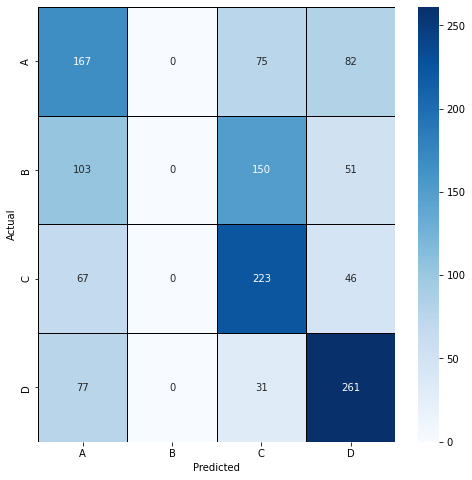

In [514]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['A','B','C','D'] , yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [515]:
tree_model = DecisionTreeClassifier()
prams ={ 'max_depth'  : [3 ,5, 7,8, 11, 12],
       'min_samples_split' : [2, 3, 5, 9] , 'criterion' : ['gini', 'entropy'] }
gd_cv2= GridSearchCV(tree_model , param_grid=prams, n_jobs=-1 ,cv=10)
gd_cv2.fit(X_train , y_train) 
tunn_tree =gd_cv2.best_estimator_

In [516]:
print(f'Train : {tunn_tree.score(X_train, y_train)}')
model_eval(tunn_tree,X_test,y_test)

Train : 0.5703300825206301
Test  : 0.5123780945236309
F(1): 0.5132505644160863
Precision : 0.5175894516811111
Recall : 0.5123780945236309


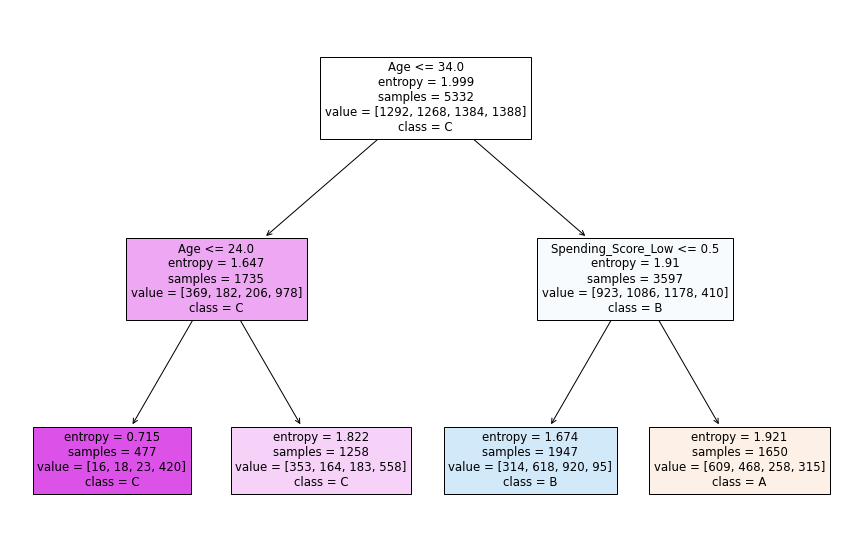

In [517]:
plt.figure(figsize=(15,10))
names = ['A', 'D', 'B', 'C']
tree.plot_tree(best_dt,feature_names = X_train.columns,class_names=names,filled = True);

<a id='random'></a>
## Random Forest Classifier

In [518]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, min_samples_leaf=25)
rf_model.fit(X_train , y_train)
print(f'Train : {rf_model.score(X_train, y_train)}')
model_eval(rf_model,X_test,y_test)

Train : 0.5453863465866466
Test  : 0.5408852213053263
F(1): 0.5326905020605736
Precision : 0.5303865775269848
Recall : 0.5408852213053263


In [519]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred =rf_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.48      0.51      0.49       324
           B       0.42      0.30      0.35       304
           C       0.56      0.60      0.58       336
           D       0.64      0.71      0.68       369

    accuracy                           0.54      1333
   macro avg       0.52      0.53      0.52      1333
weighted avg       0.53      0.54      0.53      1333



Text(51.0, 0.5, 'Actual')

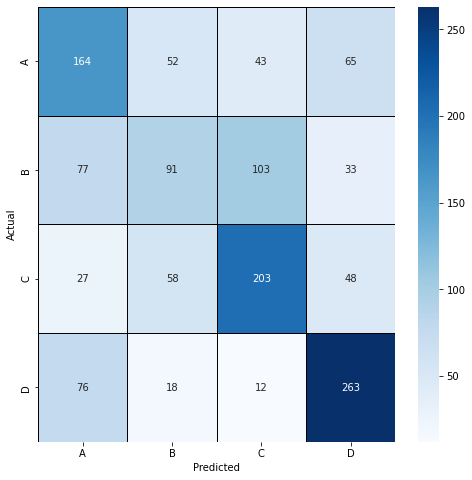

In [520]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['A','B','C','D'] , yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [521]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, min_samples_leaf=25)
prams ={ 'n_estimators':[10 ,20,40,50, 70], 'max_depth'  : [3 ,5, 7,8, 11, 12],
       'min_samples_split' : [2, 3, 5, 9] , 'criterion' : ['gini', 'entropy'], 'max_features':['auto','sqrt','log2'] }
gd_rf= GridSearchCV(rf_model , param_grid=prams, n_jobs=-1 ,cv=10)
gd_rf.fit(X_train , y_train) 
gd_rf.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_leaf=25, n_estimators=70,
                       random_state=42)

In [522]:
tuned_rf= gd_rf.best_estimator_
tuned_rf

RandomForestClassifier(max_depth=11, min_samples_leaf=25, n_estimators=70,
                       random_state=42)

In [523]:
print(f'Train : {tuned_rf.score(X_train, y_train)}')
model_eval(tuned_rf,X_test,y_test)

Train : 0.5446361590397599
Test  : 0.5393848462115529
F(1): 0.5320679476415218
Precision : 0.5297117246147893
Recall : 0.5393848462115529


<a id='xgb'></a>
# XGBClassifier

In [524]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1)
xgb.fit(X_train, y_train)
print(f'Train : {xgb.score(X_train, y_train)}')
model_eval(xgb,X_test,y_test)

[12:09:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train : 0.7610652663165791
Test  : 0.5033758439609902
F(1): 0.4994638580257167
Precision : 0.4973156405879706
Recall : 0.5033758439609902


In [525]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred =xgb.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.45      0.45      0.45       324
           B       0.35      0.30      0.32       304
           C       0.52      0.57      0.55       336
           D       0.64      0.65      0.65       369

    accuracy                           0.50      1333
   macro avg       0.49      0.49      0.49      1333
weighted avg       0.50      0.50      0.50      1333



Text(51.0, 0.5, 'Actual')

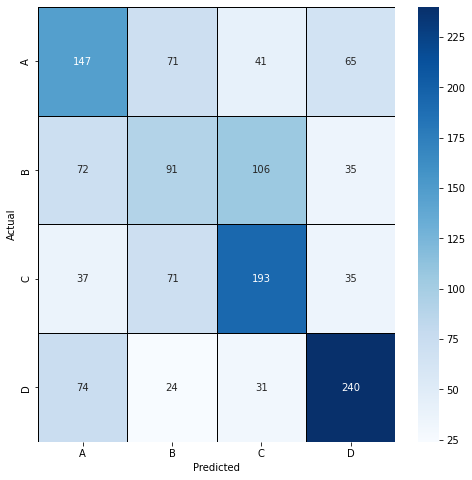

In [526]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' ,
            xticklabels = ['A','B','C','D'] , 
            yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

<a id='naive'></a>
# Gaussian Naive Bayes

In [527]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
print(f'Train : {gaussian.score(X_train, y_train)}')
model_eval(gaussian,X_test,y_test)

Train : 0.4671792948237059
Test  : 0.4876219054763691
F(1): 0.46442382097012375
Precision : 0.47193678241670267
Recall : 0.4876219054763691


In [528]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred =gaussian.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           A       0.46      0.42      0.44       324
           B       0.33      0.14      0.20       304
           C       0.43      0.67      0.52       336
           D       0.64      0.67      0.65       369

    accuracy                           0.49      1333
   macro avg       0.46      0.47      0.45      1333
weighted avg       0.47      0.49      0.46      1333



Text(51.0, 0.5, 'Actual')

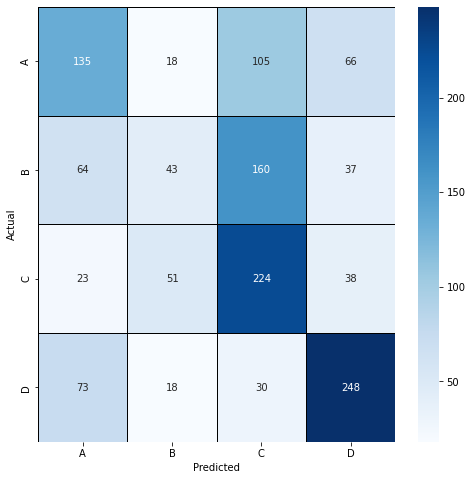

In [529]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['A','B','C','D'] , yticklabels = ['A','B','C','D'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Ensembling with Votting

#### Now, lets try fitting the different models and see the results

In [530]:

model_names = {"KNN": tuned_knn,
          "xgb": xgb,
          "Random_Forest": tuned_rf,
          "DecisionTree" :tunn_tree,
          "naive_bayes" :gaussian,
          "Logistic_Regression": tuned_lr}

In [531]:
model_names = ["tuned_knn","xgb", "tuned_rf", "tunn_tree","gaussian","tuned_lr"]
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [532]:
model_names

['tuned_knn', 'xgb', 'tuned_rf', 'tunn_tree', 'gaussian', 'tuned_lr']

In [533]:
model_list

[('tuned_knn', KNeighborsClassifier(n_neighbors=18)),
 ('xgb',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=-1,
                num_parallel_tree=1, objective='multi:softprob', predictor='auto',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                subsample=1, tree_method='exact', validate_parameters=1,
                verbosity=None)),
 ('tuned_rf',
  RandomForestClassifier(max_depth=11, min_samples_leaf=25, n_estimators=70,
                         random_state=42)),
 ('tunn_tree', DecisionTreeClassifier(max_depth=8, min_samples_split=9)),
 ('gaussian', Gaussian

In [534]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} Train score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} Test score: {curr_model.score(X_test, y_test)}')

tuned_knn Train score: 0.2972618154538635
tuned_knn Test score: 0.29182295573893474
xgb Train score: 0.7610652663165791
xgb Test score: 0.5033758439609902
tuned_rf Train score: 0.5446361590397599
tuned_rf Test score: 0.5393848462115529
tunn_tree Train score: 0.5703300825206301
tunn_tree Test score: 0.5123780945236309
gaussian Train score: 0.4671792948237059
gaussian Test score: 0.4876219054763691
tuned_lr Train score: 0.2595648912228057
tuned_lr Test score: 0.25206301575393847


In [535]:
from sklearn.ensemble import  VotingClassifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('tuned_knn',
                              KNeighborsClassifier(n_neighbors=18)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_wei...
                                            scale_pos_weight=None, subsample=1,
                                            tree_method='exact',


In [536]:
from sklearn.metrics import accuracy_score
y_pred = voting_classifer.predict(X_test)
#print(f'The score: {accuracy_score(X_test, y_pred)}')
model_eval(voting_classifer,X_test,y_test)

Test  : 0.5236309077269318
F(1): 0.5068107743608988
Precision : 0.5049764234235483
Recall : 0.5236309077269318


# BaggingClassifier

In [537]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
l2_norm = 8 #the square root of the sum of the squared vector values
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
 
Bag_ml = BaggingClassifier(base_estimator=LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations),
                            n_estimators=30, 
            random_state=0,  )

Bag_ml.fit(X_train,  y_train)
y_pred = Bag_ml.predict(X_test)
accuracy_train_set = Bag_ml.score(X_train, y_train)  #get accuracy on train set
accuracy_test_set = Bag_ml.score(X_test, y_test)  #get accuracy on test set

print("Bagging Classifier, Accuracy (Train Set) : ", accuracy_train_set)
print("Bagging Classifier, Accuracy (Test Set) : ", accuracy_test_set)

Bagging Classifier, Accuracy (Train Set) :  0.5127531882970743
Bagging Classifier, Accuracy (Test Set) :  0.5198799699924981


In [538]:
print(f'Train : {Bag_ml.score(X_train, y_train)}')
model_eval(Bag_ml,X_test,y_test)

Train : 0.5127531882970743
Test  : 0.5198799699924981
F(1): 0.49100012733498816
Precision : 0.5088912266982002
Recall : 0.5198799699924981


# Precision_Recall_Curve

In [539]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
#%matplotlib inline

n_classes = len(set(y_train))

Y = label_binarize(y_train, classes= np.unique(y_train) )


clf = OneVsRestClassifier(XGBClassifier(n_jobs = -1))
clf.fit(X_train, Y)

y_score = clf.predict_proba(X_test)


# tuned_lr.fit(X_train, y_train)

# y_score = tuned_lr.predict_proba(X_test)
# y_score


[12:11:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:19] WARNING: /Users/runner/miniforge3/cond

In [540]:
Y_test = label_binarize(y_test, classes= np.unique(y_train) )
Y_test

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [541]:
seg=y_test.unique()
seg

array(['D', 'A', 'B', 'C'], dtype=object)

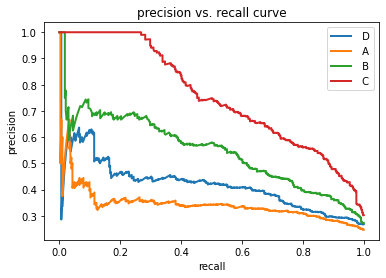

In [542]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f' { seg[i]}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [543]:
Y_test[:, 3].shape

(1333,)

# Roc Curve

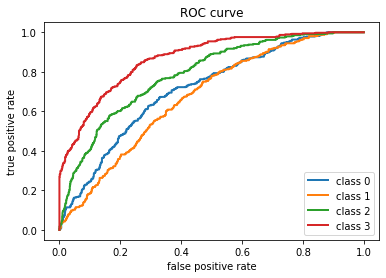

In [544]:
# roc curve
fpr = dict()
tpr = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

{0: (0.33102081268582756, 0.6728395061728395, 0.22911501), 1: (0.4042759961127308, 0.6677631578947368, 0.22695158), 2: (0.31995987963891676, 0.75, 0.19448811), 3: (0.25311203319502074, 0.8319783197831978, 0.18001734)}


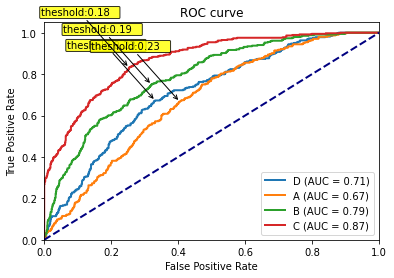

In [545]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial import distance
import matplotlib.pyplot as plt
import patsy
def optim_thres(fpr, tpr, threshold):
    TOP = np.array([0,1])
    xy = np.array(list(zip(fpr, tpr)))
    dist = [(i, distance.euclidean(TOP, v)) for i,v in enumerate(xy)]
    dist.sort(key = lambda x: x[1], reverse=False)
    i, d = dist[0]
    return (fpr[i], tpr[i], threshold[i])

# Compute ROC curve and ROC area for each class
TOP = np.array([0,1])
fpr = dict()
tpr = dict()
thres = dict()
roc_auc = dict()
optim = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ## next find optimal thres
    optim[i] = optim_thres(fpr[i], tpr[i], thres[i])

print(optim)

plt.figure()
lw = 2
axes = []
for i in range(n_classes):
    ax, = plt.plot(fpr[i], tpr[i], 
            lw=lw, label=f'{seg[i]} (AUC = %0.2f)' % roc_auc[i])
    axes.append(ax)
    _fpr, _tpr, _thres, = optim[i]
    label = f'theshold:{str(round(_thres, 2))}   '
    plt.annotate(
        label,
        xy=(_fpr, _tpr), xytext=(-10,50),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.8),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right") 
plt.show()

##### Summary of data modeling
Summary of data modeling
It can be found that all the performance are generally not very good,However Refer to the accuracy list above, XGBClassifier seems to be the best approach. However, would suggest to have a better sampling again for better data modeling.